# Discrete flashing ratchet model

In [1]:
import sys

sys.path.append('..')

In [2]:
from argparse import Namespace

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy import stats
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from misc.sampler import CartesianSampler
from toy.ratchet import simulation, ep_per_step, analytic_etpy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%config InlineBackend.figure_format = 'retina'

## NEEP 

In [3]:
class NEEP(nn.Module):
    def __init__(self, opt):
        super(NEEP, self).__init__()
        self.encoder = nn.Embedding(opt.n_token, opt.n_hidden)
        self.h = nn.Sequential()
        for i in range(opt.n_layer):
            self.h.add_module(
                'fc%d' % (i+1), nn.Linear(2*opt.n_hidden, 2*opt.n_hidden))
            self.h.add_module(
                'relu%d' % (i+1), nn.ReLU())
        self.h.add_module(
            'out', nn.Linear(2*opt.n_hidden, 1))

    def forward(self, s1, s2):
        s1 = self.encoder(s1)
        s2 = self.encoder(s2)
        x = torch.cat([s1, s2], dim=-1)
        _x = torch.cat([s2, s1], dim=-1)
        return self.h(x) - self.h(_x)

### Training Algorithm

In [4]:
def train(opt, model, optim, trajs, sampler):
    model.train()
    batch, next_batch = next(sampler)

    s_prev = trajs[batch].to(opt.device)
    s_next = trajs[next_batch].to(opt.device)
    ent_production = model(s_prev, s_next)
    optim.zero_grad()
    
    # The objective function J. Equation (2)
    loss = (-ent_production + torch.exp(-ent_production)).mean()
    loss.backward()
    optim.step()
    return loss.item()


def validate(opt, model, trajs, sampler):
    model.eval()

    ret = []
    loss = 0
    with torch.no_grad():
        for batch, next_batch in sampler:
            s_prev = trajs[batch].to(opt.device)
            s_next = trajs[next_batch].to(opt.device)
            
            ent_production = model(s_prev, s_next)
            entropy = ent_production.cpu().squeeze().numpy()
            ret.append(entropy)
            loss += (- ent_production + torch.exp(-ent_production)).sum().cpu().item()
    loss = loss / sampler.size
    ret = np.concatenate(ret)
    ret = ret.reshape(trajs.shape[0], trajs.shape[1]-1)
    return ret, loss

### Hyper-parameters

In [5]:
opt = Namespace()
opt.device = 'cuda:0' 
opt.batch_size = 4096
opt.test_batch_size = 50000
opt.n_token = 6
opt.n_hidden = 128
opt.n_layer = 1

opt.lr = 0.0001
opt.wd = 5e-5

opt.record_freq = 1000
opt.seed = 398

torch.manual_seed(opt.seed)

# Trajectory sampling

In [6]:
opt.M = 1             # number of trajectories
opt.L = 1000000       # lenth of a trjectory 
opt.V = 3             # potential 

data = simulation(2*opt.M, opt.L, opt.V, seed=0)
trajs = data[0]
test_trajs = data[1]

trajs_t = torch.from_numpy(trajs).long().view(1,-1,1)
test_trajs_t = torch.from_numpy(test_trajs).long().view(1,-1,1)

## Build model & Training

In [7]:
model = NEEP(opt)
model = model.to(opt.device)
optim = torch.optim.Adam(model.parameters(), opt.lr, weight_decay=opt.wd)

train_sampler = CartesianSampler(opt.M, opt.L, opt.batch_size, device=opt.device)
test_sampler = CartesianSampler(opt.M, opt.L, opt.test_batch_size, device=opt.device, train=False)

opt.n_iter = 50000 # number of training iteration

for i in tqdm(range(1, opt.n_iter + 1)):
    train(opt, model, optim, trajs_t, train_sampler)

### Testing

In [8]:
pred, _ = validate(opt, model, test_trajs_t, test_sampler)
pred = pred.flatten()
ent = analytic_etpy(test_trajs_t.numpy()[0, :, 0], opt.V)

cum_pred = np.cumsum(pred)
cum_ent = np.cumsum(ent)

## Results

### Single trajectory EP

Analytic EP per step : 0.3982
Estimated EP per step : 0.3967


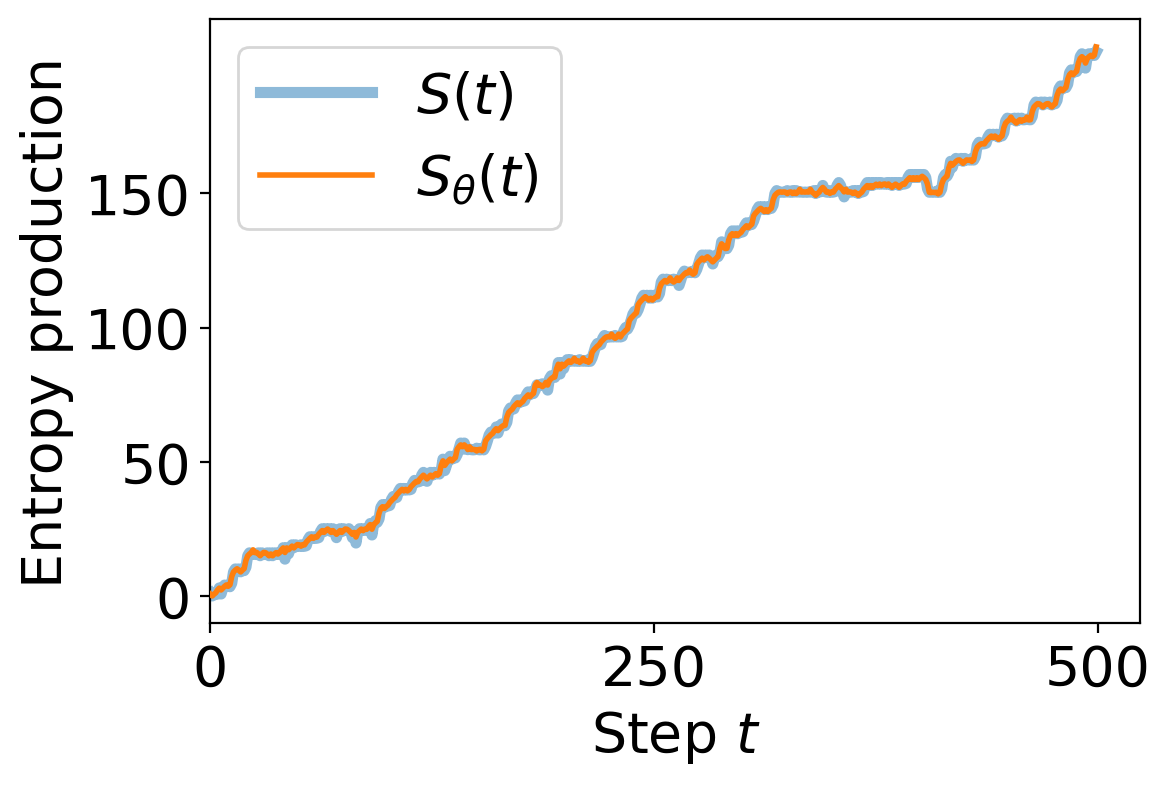

In [9]:
start = 0
end = 500

plt.figure(dpi=100)
plt.plot(cum_ent[start:end], label=r"$S(t)$", lw=4.0, zorder=1, alpha=0.5)
plt.plot(cum_pred[start:end], label='$S_\\theta(t)$', lw=2.0, zorder=10)
plt.xticks([0, 250, 500], fontsize=20)
plt.yticks([0, 50, 100, 150], fontsize=20)
plt.xlim(0)

plt.xlabel("Step $t$", fontsize=20)
plt.ylabel("Entropy production", fontsize=20)
plt.legend(fontsize=20)

slope, _, _, _, _ = stats.linregress(range(len(cum_pred)), cum_pred)
print("Analytic EP per step : %.4f" %ep_per_step(opt.V))
print("Estimated EP per step : %.4f" %slope)